# Variational Auto Encoder


#### Imports

In [2]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data
from torchvision import datasets, transforms

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import numpy as np

from sklearn.metrics import roc_curve, auc

In [3]:
import seaborn as sns
sns.set(style="ticks")

#### Global variables

In [4]:
batch_size = 128
epochs = 15
seed = 42
log_interval = 30

cuda = torch.cuda.is_available()
print("Cuda:", cuda)

Cuda: True


In [5]:
torch.manual_seed(seed)
device = torch.device('cuda' if cuda else 'cpu')

### Helper functions

In [6]:
MNIST_TRAIN = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
MNIST_TEST = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

def create_loader(train=True, batch_size=128, allowable=[]):
    dataset = MNIST_TRAIN if train else MNIST_TEST
    
    if not allowable:
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    labels = MNIST_TRAIN.train_labels if train else MNIST_TEST.test_labels
    indices = torch.zeros_like(labels).type(torch.ByteTensor)

    for i in allowable:
        indices |= (labels == i)

    sampler = torch.utils.data.sampler.SubsetRandomSampler(indices.nonzero().view(-1))

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

def create_loader_share(train=True, batch_size=128, share=[]):
    dataset = MNIST_TRAIN if train else MNIST_TEST
    
    if not share:
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    labels = MNIST_TRAIN.train_labels if train else MNIST_TEST.test_labels
    indices = []

    for i, s in share:
        idx = (labels == i).nonzero()
        indices.extend(np.random.choice(idx.squeeze(), int(len(idx) * s), replace=False).tolist())

    sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

#### Visualization

In [7]:
def reconstruct_images(model, loader, w=28, h=28, n=11):
    reconstructed = np.empty((h * n, 2 * w * n))

    with torch.no_grad():
        batch, _ = next(iter(loader))
        batch = batch.to(device)

        recon_x, mu, logvar = model.forward(batch)

        recon_x = recon_x.cpu()
        batch = batch.cpu()

        for i in range(n):
            for j in range(n):
                x = np.concatenate((batch[i * n + j].view(h, w), recon_x[i * n + j].view(h, w)), axis=1)
                reconstructed[i * h : (i + 1) * h, j * 2 * w : (j + 1) * 2 * w] = x

    plt.figure(figsize=(10, 15))
    plt.grid(False)
    plt.imshow(reconstructed, cmap='gray')
    plt.axis('off')

    plt.show()
    
def generate_images(model, w=28, h=28, n=11):
    generated = np.empty((h * n, w * n))

    with torch.no_grad():
        sample = torch.randn(128, 20).to(device)
        sample = model.decode(sample).cpu()

        for i in range(n):
            for j in range(n):
                generated[i * h : (i + 1) * h, j * w : (j + 1) * w] = sample[i * n + j].view(w, h)

    plt.figure(figsize=(6, 6))
    plt.grid(False)
    plt.imshow(generated, cmap='gray')
    plt.axis('off')

    plt.show()
    
def plot_2d_latent(model, loader):
    with torch.no_grad():
        batch, label = next(iter(loader))
        batch = batch.to(device)

        mu, logvar = model.encode(batch.view(-1, 784))
        z = model.reparameterize(mu, logvar)

    z = z.cpu().numpy()

    plt.figure(figsize=(6, 5), dpi=100)
    plt.grid(True, lw=0.3)
    plt.scatter(z[:, 0], z[:, 1], c=label, cmap='jet', s=4, alpha=0.7)
    plt.colorbar()

    plt.show()
    
def decode_2d_latent_space(model, x_min, x_max, y_min, y_max, w=28, h=28, n=11):
    n = 20
    latent = np.empty(((h * n, w * n)))

    with torch.no_grad():
        x = torch.linspace(x_min, x_max, n)
        y = torch.linspace(y_min, y_max, n)

        for i, yi in enumerate(x):
            for j, xi in enumerate(y):
                z = torch.tensor([yi, xi]).to(device)
                recon_x = model.decode(z).cpu()
                latent[(n - i - 1) * h : (n - i) * h, j * w : (j + 1) * w] = recon_x.view(w, h)

    plt.figure(figsize=(6, 6))
    plt.grid(False)
    plt.imshow(latent, cmap='gray')

    plt.show()
    
def plot_latent_dev(model, loader):
    with torch.no_grad():
        batch, label = next(iter(loader))
        batch = batch.to(device)

        mu, logvar = model.encode(batch.view(-1, 784))
        std = torch.exp(0.5 * logvar)

    mu = mu.cpu().numpy()
    std = std.cpu().numpy()

    for i in range(std.shape[1]):
        print(std[:, i].min(), std[:, i].max(), std[:, i].mean(), np.median(std[:, i]))
        plt.axvline(std[:, i].mean(), color='red')
        plt.hist(std[:, i], bins=100)
        plt.show()
        
def plot_versus_latent_dev(model, separate, *loaders):
    batches = []
    
    for loader in loaders:
        batch, _ = next(iter(loader))
        batch = batch.to(device)
        batches.append(batch)
        
    stds = []
    
    with torch.no_grad():
        for batch in batches:
            _, logvar = model.encode(batch.view(-1, 784))
            std = torch.exp(0.5 * logvar)
            stds.append(std)

    stds = [std.cpu().numpy().T for std in stds]
    dim = stds[0].shape[0]
    
    if not separate:
        stds, dim = [std.sum(axis=0).reshape(1, -1) for std in stds], 1

    for i in range(dim):
        plt.figure(figsize=(12, 2))
        for c, std in enumerate(stds):
            print("min: {}, max: {}, mean: {}, median: {}".format(
                std[i].min(), std[i].max(), std[i].mean(), np.median(std[i])))
            plt.axvline(std[i].mean(), color='red')
            plt.hist(std[i], bins=100, alpha=0.85, label=str(c))
        plt.legend()
        plt.show()
        
def plot_train_process(train_losses, test_losses):
    plt.plot(train_losses, label='train', c='blue')
    plt.plot(test_losses, label='test', c='red', linestyle='dashed')

    plt.legend()
    plt.show()
    
def plot_reconstruction_error(model, *loaders):
    batches = []
    
    for loader in loaders:
        batch, _ = next(iter(loader))
        batch = batch.to(device)
        batches.append(batch)
        
    losses = []
        
    with torch.no_grad():
        for batch in batches:
            recon_batch, _, _ = model.forward(batch.view(-1, 784))
            loss = ((recon_batch - batch.view(-1, 784))**2).sum(dim=1).cpu().numpy()
            losses.append(loss)
            
    plt.figure(figsize=(12, 2))
    plt.title('Reconstruction error')
    
    for c, loss in enumerate(losses):
        print("min: {}, max: {}, mean: {}, median: {}".format(loss.min(), loss.max(), loss.mean(), np.median(loss)))
        plt.axvline(loss.mean(), color='red')
        plt.hist(loss, bins=100, alpha=0.85, label=str(c))
        
    plt.legend()
    plt.show()

In [8]:
def reconstruct_images(model, loader, w=28, h=28, n=9):
    reconstructed = np.empty((h * n, 2 * w * n))

    with torch.no_grad():
        batch, _ = next(iter(loader))
        batch = batch.to(device)

        recon_x, mu, logvar = model.forward(batch)

        recon_x = recon_x.cpu()
        batch = batch.cpu()

        for i in range(n):
            for j in range(n):
                x = np.concatenate((batch[i * n + j].view(h, w), recon_x[i * n + j].view(h, w)), axis=1)
                reconstructed[i * h : (i + 1) * h, j * 2 * w : (j + 1) * 2 * w] = x

    plt.figure(figsize=(10, 15))
    plt.grid(False)
    plt.imshow(reconstructed, cmap='gray')
    plt.axis('off')

    plt.show()

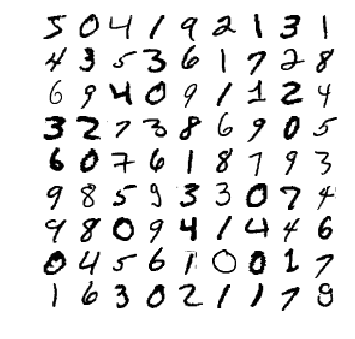

In [9]:
n = 9
grid = np.empty((28 * n, 28 * n))

for i in range(n):
    for j in range(n):
        grid[i * 28 :  (i + 1) * 28, j * 28 : (j + 1) * 28] = MNIST_TRAIN.train_data[i * n + j]
        
plt.figure(figsize=(5, 5))
plt.imshow(grid, cmap='gray_r')
plt.axis('off')
plt.tight_layout()
plt.show()

#### Train

In [10]:
def train_epoch(model, optimizer, loader, epoch, debug=2):
    model.train()
    
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = model.loss_function(data, recon_batch, mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        
        if debug > 1 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(loader),
                100. * batch_idx / len(loader),
                loss.item() / len(data)))

    avg_loss = train_loss / (len(loader) * loader.batch_size)
    if debug > 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, avg_loss))
    
    return avg_loss

#### Test

In [11]:
def test_epoch(model, loader, epoch, debug=1):
    model.eval()
    
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(loader):
            data = data.to(device)
            
            recon_batch, mu, logvar = model(data)
            
            test_loss += model.loss_function(data, recon_batch, mu, logvar).item()

    test_loss /= len(loader) * loader.batch_size
    if debug > 0:
        print('====> Test set loss: {:.4f}'.format(test_loss))
    
    return test_loss

#### Create model

In [12]:
class VAE(nn.Module):
    def __init__(self, z_dim=20):
        super().__init__()

        self.z_dim = z_dim

        self.fc1  = nn.Linear(28**2, 400)
        self.fc21 = nn.Linear(400, self.z_dim)
        self.fc22 = nn.Linear(400, self.z_dim)
        self.fc3  = nn.Linear(self.z_dim, 400)
        self.fc4  = nn.Linear(400, 28**2)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 28**2)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def MSE_loss(self, x, recon_x):
        x = x.view(-1, 28**2)
        return ((recon_x - x) ** 2).sum(1)
    
    def BCE_loss(self, x, recon_x):
        return F.binary_cross_entropy(recon_x, x.view(-1, 28**2), reduction='none').sum(1)

    
    def KLD_loss(self, mu, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        return (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())).sum(1)
    
    def loss_function(self, x, recon_x, mu, logvar, extended=False):
        BCE = self.BCE_loss(x, recon_x)
        KLD = self.KLD_loss(mu, logvar)

        loss = BCE.sum() + KLD.sum()
        return (loss, BCE, KLD) if extended else loss

In [13]:
def train(model, train_loader, test_loader=None, epochs=epochs, debug=1, plot=True):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    train_losses, test_losses = [], []

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, optimizer, train_loader, epoch, debug=debug)
        train_losses.append(train_loss)

        if test_loader is not None:
            test_loss = test_epoch(model, test_loader, epoch, debug=debug)
            test_losses.append(test_loss)
            
    model.eval()
    
    if plot:
        plot_train_process(train_losses, test_losses)

#### Models

In [13]:
train_loader = create_loader(train=True, batch_size=batch_size)
test_loader = create_loader(train=False, batch_size=batch_size)

model = VAE().cuda()

Train Epoch: 1 [0/469 (0%)]	Loss: 547.430908
Train Epoch: 1 [30/469 (6%)]	Loss: 214.055969
Train Epoch: 1 [60/469 (13%)]	Loss: 207.294266
Train Epoch: 1 [90/469 (19%)]	Loss: 190.157089
Train Epoch: 1 [120/469 (26%)]	Loss: 176.967651
Train Epoch: 1 [150/469 (32%)]	Loss: 155.518723
Train Epoch: 1 [180/469 (38%)]	Loss: 153.709305
Train Epoch: 1 [210/469 (45%)]	Loss: 150.956070
Train Epoch: 1 [240/469 (51%)]	Loss: 145.388870
Train Epoch: 1 [270/469 (58%)]	Loss: 144.101044
Train Epoch: 1 [300/469 (64%)]	Loss: 139.302887
Train Epoch: 1 [330/469 (70%)]	Loss: 139.829498
Train Epoch: 1 [360/469 (77%)]	Loss: 136.230667
Train Epoch: 1 [390/469 (83%)]	Loss: 135.566879
Train Epoch: 1 [420/469 (90%)]	Loss: 130.071991
Train Epoch: 1 [450/469 (96%)]	Loss: 124.682999
====> Epoch: 1 Average loss: 163.9456
====> Test set loss: 116.9237
Train Epoch: 2 [0/469 (0%)]	Loss: 130.205002
Train Epoch: 2 [30/469 (6%)]	Loss: 131.508789
Train Epoch: 2 [60/469 (13%)]	Loss: 126.559036
Train Epoch: 2 [90/469 (19%)]	Los

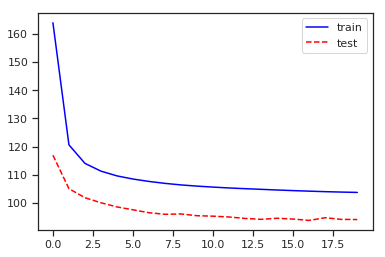

In [14]:
train(model, train_loader, test_loader, epochs=20, debug=2)

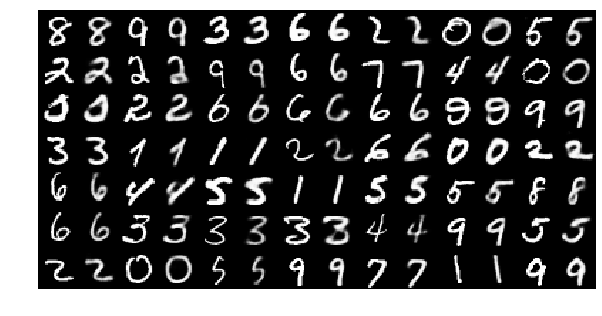

In [15]:
reconstruct_images(model, train_loader, n=7)

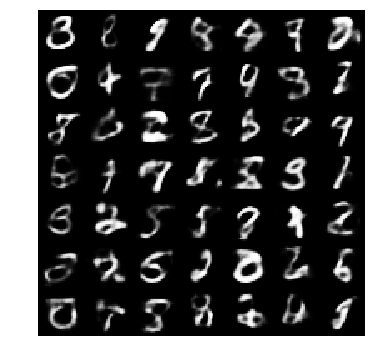

In [16]:
generate_images(model, n=7)

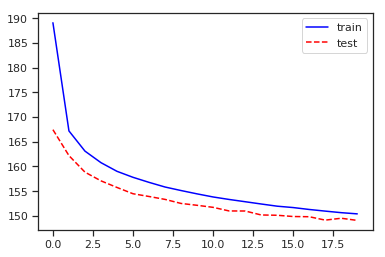

Finished training model with z_dim=2


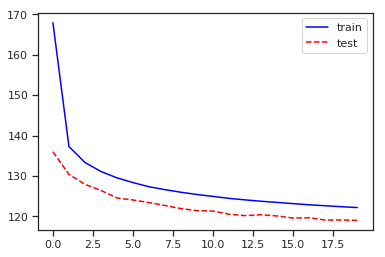

Finished training model with z_dim=5


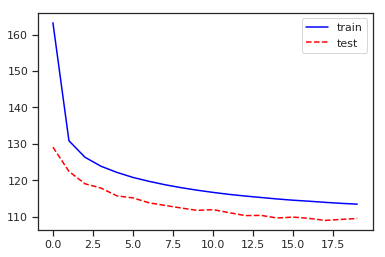

Finished training model with z_dim=7


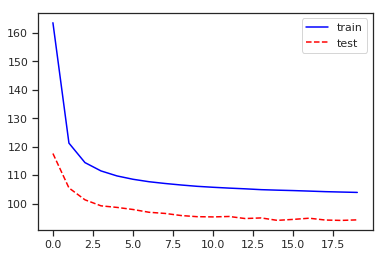

Finished training model with z_dim=20


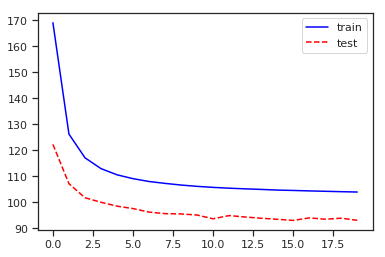

Finished training model with z_dim=50


In [17]:
models = {}

for z_dim in [2, 5, 7, 20, 50]:
    train_loader = create_loader(train=True, batch_size=batch_size)
    test_loader = create_loader(train=False, batch_size=batch_size)
    
    model = VAE(z_dim).cuda()
    train(model, train_loader, test_loader, epochs=20, debug=0)
    
    models[z_dim] = model
    print(f'Finished training model with z_dim={z_dim}')

In [18]:
indices = [np.random.choice((MNIST_TRAIN.train_labels == i).nonzero().view(-1)) for i in range(10)]

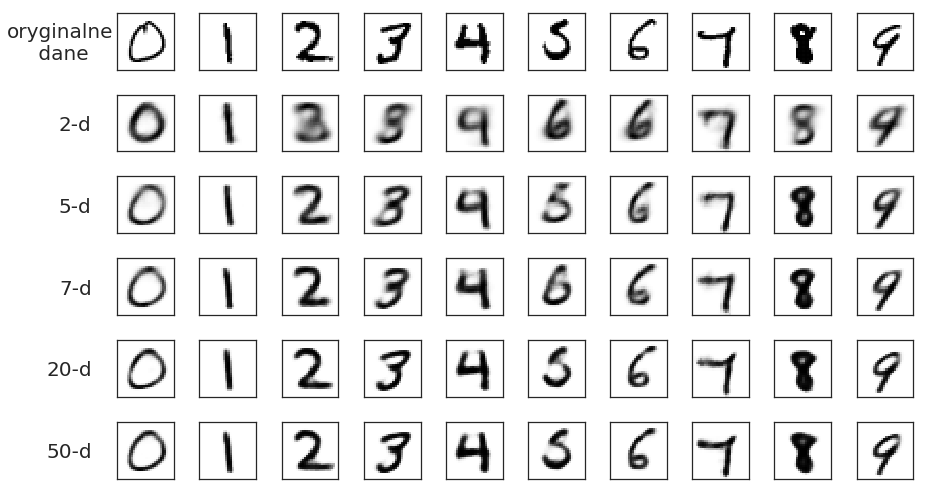

In [19]:
fig, axes = plt.subplots(len(models) + 1, len(indices), figsize=(13, 7))

images = MNIST_TRAIN.train_data[indices].float() / 255

for ax in axes.flatten():
#     ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(images)):
    axes[0, i].imshow(images[i], cmap='gray_r')
axes[0, 0].set_ylabel('oryginalne\n dane', rotation=0, fontsize=20, labelpad=40)
axes[0, 0].yaxis.set_label_coords(-1, 0.1) 
    
with torch.no_grad():
    for i, z_dim in enumerate(models.keys(), 1):
        model = models[z_dim]
        output, _, _ = model.forward(images.cuda().view(-1, 784))
        output = output.reshape(-1, 28, 28).cpu()
        for j in range(len(output)):
            axes[i, j].imshow(output[j], cmap='gray_r')
        axes[i, 0].set_ylabel(f'{z_dim}-d', rotation='horizontal', fontsize=20, labelpad=20, ha='right')
        axes[i, 0].yaxis.set_label_coords(-0.45, 0.3)

# plt.subplots_adjust(wspace=0.4, hspace=0.1)
plt.tight_layout()
plt.show()

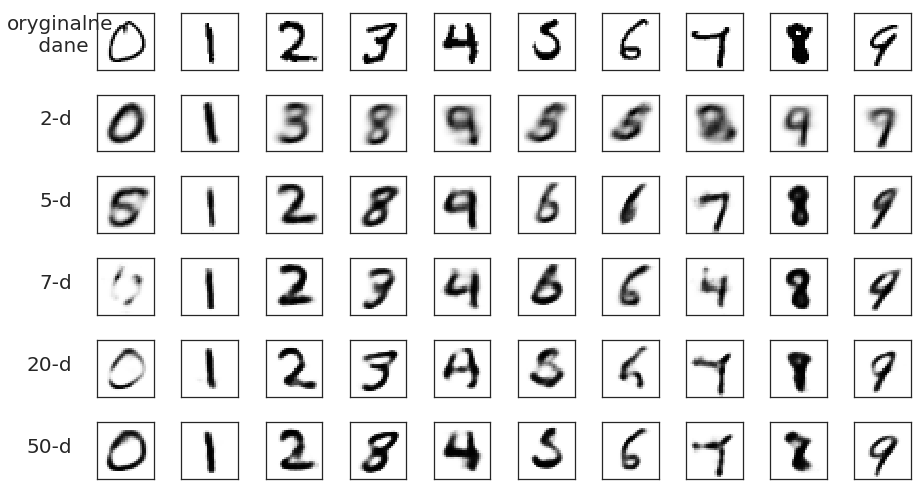

In [20]:
fig, axes = plt.subplots(len(models) + 1, len(indices), figsize=(13, 7))

images = MNIST_TRAIN.train_data[indices].float() / 255

for ax in axes.flatten():
#     ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(images)):
    axes[0, i].imshow(images[i], cmap='gray_r')
axes[0, 0].set_ylabel('oryginalne\n dane', rotation=0, fontsize=20, labelpad=40)
axes[0, 0].yaxis.set_label_coords(-0.65, 0.25) 
    
with torch.no_grad():
    for i, z_dim in enumerate(models.keys(), 1):
        model = models[z_dim]
        
        z, _ = model.encode(images.cuda().reshape(-1, 28**2))
        
        z += torch.randn_like(z) / 2.
        
        output = model.decode(z)
        output = output.reshape(-1, 28, 28).cpu()
        
        for j in range(len(output)):
            axes[i, j].imshow(output[j], cmap='gray_r')
        axes[i, 0].set_ylabel(f'{z_dim}-d', rotation='horizontal', fontsize=20, labelpad=20, ha='right')
        axes[i, 0].yaxis.set_label_coords(-0.45, 0.4)

# plt.subplots_adjust(wspace=0.4, hspace=0.1)
plt.tight_layout()
plt.show()

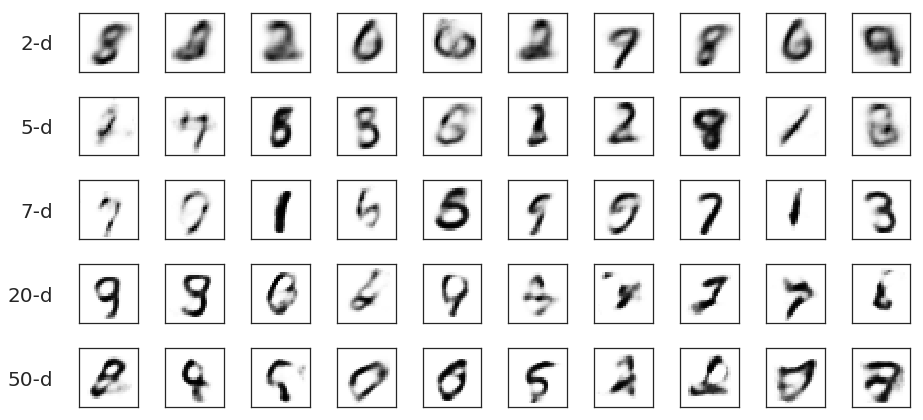

In [21]:
fig, axes = plt.subplots(len(models), 10, figsize=(13, 6))

for ax in axes.flatten():
#     ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    
with torch.no_grad():
    for i, z_dim in enumerate(models.keys()):
        model = models[z_dim]
        
        z = torch.randn(10, z_dim).cuda()
        
        output = model.decode(z)
        output = output.reshape(-1, 28, 28).cpu()
        
        for j in range(len(output)):
            axes[i, j].imshow(output[j], cmap='gray_r')
        axes[i, 0].set_ylabel(f'{z_dim}-d', rotation='horizontal', fontsize=20, labelpad=20, ha='right')
        axes[i, 0].yaxis.set_label_coords(-0.45, 0.3)

# plt.subplots_adjust(wspace=0.4, hspace=0.1)
plt.tight_layout()
plt.show()

In [22]:
model_losses = {}

with torch.no_grad():
    for i, z_dim in enumerate(models.keys(), 1):
        model = models[z_dim]
        
        losses = []
        for i, (data, _) in enumerate(test_loader):
            
            recon_batch, _, _ = model(data.cuda())
            output = recon_batch.reshape(-1, 1, 28, 28).cpu()
            
            losses.append(((data - output)**2).view(-1, 1 * 28 * 28).sum(1))

        model_losses[z_dim] = torch.cat(losses)

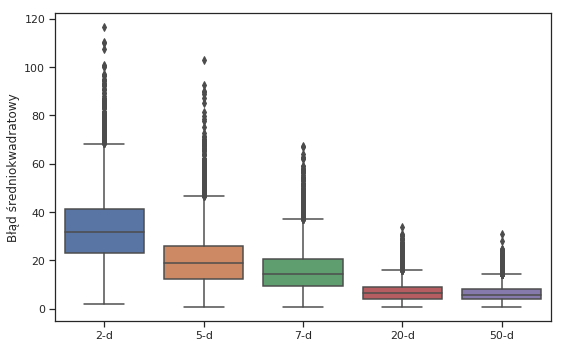

In [23]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=list(model_losses.values()))
plt.xticks(plt.xticks()[0], map(lambda k: f'{k}-d', model_losses.keys()))

plt.ylabel('Błąd średniokwadratowy')

plt.tight_layout()
plt.show()

In [24]:
train_loader = create_loader(train=True, batch_size=batch_size)
test_loader = create_loader(train=False, batch_size=batch_size)

model2d = VAE(z_dim=2).cuda()

====> Epoch: 1 Average loss: 188.1507
====> Test set loss: 166.2990
====> Epoch: 2 Average loss: 166.8039
====> Test set loss: 161.1020
====> Epoch: 3 Average loss: 163.1437
====> Test set loss: 158.6605
====> Epoch: 4 Average loss: 161.0924
====> Test set loss: 157.3433
====> Epoch: 5 Average loss: 159.6218
====> Test set loss: 155.6559
====> Epoch: 6 Average loss: 158.4753
====> Test set loss: 154.8835
====> Epoch: 7 Average loss: 157.4823
====> Test set loss: 153.8494
====> Epoch: 8 Average loss: 156.6001
====> Test set loss: 153.4345
====> Epoch: 9 Average loss: 155.8957
====> Test set loss: 152.9555
====> Epoch: 10 Average loss: 155.2132
====> Test set loss: 152.0724
====> Epoch: 11 Average loss: 154.5647
====> Test set loss: 151.8225
====> Epoch: 12 Average loss: 154.0255
====> Test set loss: 151.4311
====> Epoch: 13 Average loss: 153.4497
====> Test set loss: 151.0497
====> Epoch: 14 Average loss: 152.9643
====> Test set loss: 150.3081
====> Epoch: 15 Average loss: 152.4404
====

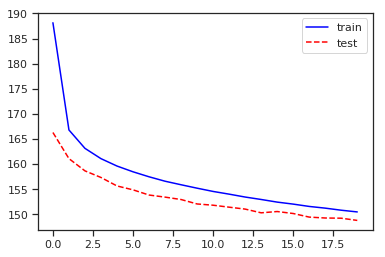

In [25]:
train(model2d, train_loader, test_loader, epochs=20)

In [26]:
model2d.train()

Mu = []
Std = []
Labels = []
Images = []

with torch.no_grad():
    for i, (data, labels) in enumerate(train_loader):
        
        mu, logvar = model2d.encode(data.cuda().reshape(-1, 28**2))
        std = torch.exp(0.5 * logvar)

        Mu.append(mu)
        Std.append(std)
        Labels.append(labels)
        Images.append(data)

Mu = torch.cat(Mu)
Std = torch.cat(Std)
Labels = torch.cat(Labels)
Images = torch.cat(Images)

In [27]:
k = 40

MuPart = Mu[::k]
StdPart = Std[::k]
LabelsPart = Labels[::k]
ImagesPart = Images[::k]

In [21]:
colors = np.array([
    [166,206,227],
    [31,120,180],
    [178,223,138],
    [51,160,44],
    [251,154,153],
    [227,26,28],
    [253,191,111],
    [255,127,0],
    [202,178,214],
    [106,61,154],
]) / 255.0

colors_init = np.hstack((colors, np.zeros((colors.shape[0], 1))))
colors_full = np.hstack((colors, np.ones((colors.shape[0], 1))))

cmaps = [matplotlib.colors.LinearSegmentedColormap.from_list("S0", [colors_init[i], colors_full[i]]) for i in range(colors.shape[0])]

plt.figure(figsize=(15, 15))

for mu, std, label, image in zip(MuPart, StdPart, LabelsPart, ImagesPart):
    plt.gca().add_patch(patches.Ellipse(mu, 2*std[0], 2*std[1], alpha=0.3, facecolor=colors[label]))
    plt.gca().imshow(image.squeeze(), extent=[mu[0]-0.1, mu[0]+0.1, mu[1]-0.1, mu[1]+0.1], cmap=cmaps[label])

plt.grid(True)

border = 3.5

plt.xlim(-border, border)
plt.ylim(-border, border)

plt.tight_layout()
plt.show()

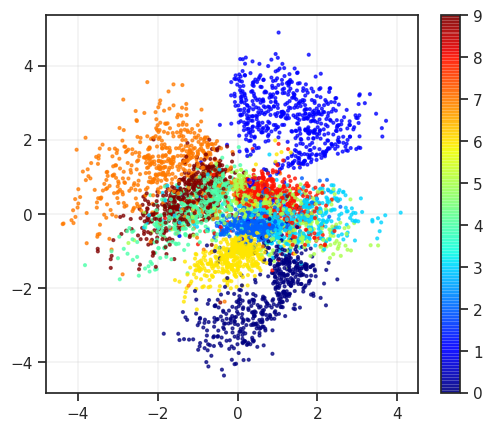

In [29]:
loader = create_loader(train=True, batch_size=5000)

plot_2d_latent(model2d, loader)

In [14]:
train_loader = create_loader_share(train=True, share=[(5, 0.01), (4, 1.), (7, 1.)])
test_loader = create_loader(train=False, allowable=[4, 7])

model = VAE(z_dim=10).cuda()

====> Epoch: 1 Average loss: 205.9125
====> Test set loss: 143.8943
====> Epoch: 2 Average loss: 135.6452
====> Test set loss: 119.4531
====> Epoch: 3 Average loss: 120.5842
====> Test set loss: 109.2468
====> Epoch: 4 Average loss: 112.0776
====> Test set loss: 101.7726
====> Epoch: 5 Average loss: 106.7244
====> Test set loss: 97.8972
====> Epoch: 6 Average loss: 103.5642
====> Test set loss: 96.0303
====> Epoch: 7 Average loss: 101.4928
====> Test set loss: 93.8965
====> Epoch: 8 Average loss: 100.0307
====> Test set loss: 92.6642
====> Epoch: 9 Average loss: 98.8656
====> Test set loss: 91.9885
====> Epoch: 10 Average loss: 97.9897
====> Test set loss: 91.9221
====> Epoch: 11 Average loss: 97.1952
====> Test set loss: 90.9339
====> Epoch: 12 Average loss: 96.5834
====> Test set loss: 90.1627
====> Epoch: 13 Average loss: 96.0358
====> Test set loss: 90.2306
====> Epoch: 14 Average loss: 95.5069
====> Test set loss: 89.7773
====> Epoch: 15 Average loss: 95.1490
====> Test set loss: 

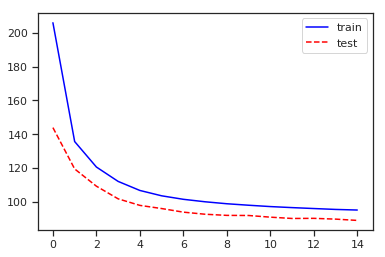

In [15]:
train(model, train_loader, test_loader)

In [16]:
test_loader = create_loader(train=False, batch_size=batch_size, allowable=[4, 7, 5])

# plot_versus_latent_dev(model, False, loader1, loader2)
# plot_reconstruction_error(model, loader1, loader2)

In [17]:
model.eval()
    
samples = len(test_loader.sampler.indices)
X, Y = np.zeros((2, samples)), np.zeros(samples)
I = np.zeros((samples, 1, 28, 28))

with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
        data = data.cuda()

        recon_data, mu, logvar = model(data)
        _, bce, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)

        X[:, i * batch_size : i * batch_size + len(data)] = torch.stack([bce, kld]).cpu()
        Y[i * batch_size : i * batch_size + len(data)] = labels
        I[i * batch_size : i * batch_size + len(data)] = data.cpu()

# fig = plt.figure(figsize=(20, 20))
# gs = gridspec.GridSpec(6, 6)

# ax_main = plt.subplot(gs[1:6, :5], adjustable='box', aspect='equal')
# ax_xDist = plt.subplot(gs[0, :5], sharex=ax_main)
# ax_yDist = plt.subplot(gs[1:6, 5], sharey=ax_main)

# for i, label in [([4, 7], '[4, 7]'), ([5], '[5]')]:
#     indices = np.in1d(Y, i).nonzero()
#     x, y = X[:, indices].squeeze()
#     ax_main.scatter(x, y, s=3, alpha=0.7, label=label)
#     ax_xDist.hist(x, bins=100, histtype='step')
#     ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='step')

# # ax_main.set(xlabel="BCE", ylabel="KLD", title=f'Compare losses for labeled images')
# ax_main.legend()
# ax_main.axis('scaled')

# # plt.tight_layout()
# plt.show()

In [18]:
data.shape

torch.Size([86, 1, 28, 28])

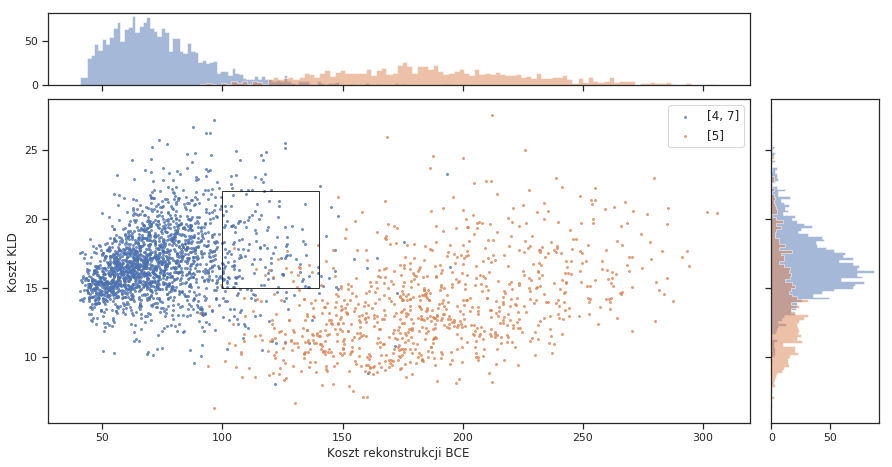

In [19]:
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.45
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.1]
rect_histy = [left_h, bottom, 0.1, height]

# start with a rectangular Figure
plt.figure(1, figsize=(15, 10))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# axScatter.set_ylim(5, 70)

# axins = zoomed_inset_axes(axScatter, 4.5, loc=1) # zoom-factor: 2.5, location: upper-left

for i, label in [([4, 7], '[4, 7]'), ([5], '[5]')]:
    indices = np.in1d(Y, i).nonzero()
    x, y = X[:, indices].squeeze()
#     axins.scatter(x, y, s=3, alpha=0.7, label=label)
    axScatter.scatter(x, y, s=4, alpha=0.7, label=label)
    axHistx.hist(x, bins=100, histtype='stepfilled', alpha=0.5)
    axHisty.hist(y, bins=100, orientation='horizontal', histtype='stepfilled', alpha=0.5)
    
#     for j in indices[0]:
#         axins.imshow(I[j].squeeze(), extent=[X[0, j]-.5, X[0, j]+.5, X[1, j]-.5, X[1, j]+.5], cmap=cmaps[7 if i == [5] else 1])

# axScatter.axis('scaled')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.add_patch(patches.Rectangle((100, 15), 40, 7, alpha=0.8, edgecolor='black', fill=False, lw=1))

# axins.set_xlim(100, 220)
# axins.set_ylim(15, 25)

# axins.set_yticks([])
# axins.set_xticks([])

# axScatter.axis('scaled')

axScatter.legend(fontsize=12)
axScatter.set_xlabel('Koszt rekonstrukcji BCE')
axScatter.set_ylabel('Koszt KLD')

# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(axScatter, axins, loc1=2, loc2=1, fc="none", ec="0.5")

plt.show()


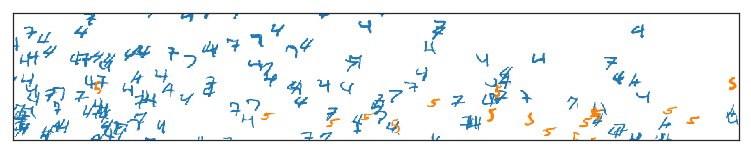

In [22]:
plt.figure(figsize=(13, 5))

for i, label in [([4, 7], '[4, 7]'), ([5], '[5]')]:
    indices = np.in1d(Y, i).nonzero()
    for j in indices[0]:
        plt.imshow(I[j].squeeze(), extent=[X[0, j]-.5, X[0, j]+.5, X[1, j]-.5, X[1, j]+.5], cmap=cmaps[7 if i == [5] else 1])

plt.ylim(15, 22)
plt.xlim(100, 140)

plt.xticks([])
plt.yticks([])

plt.show()

In [26]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=10, bias=True)
  (fc22): Linear(in_features=400, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

<Figure size 1440x1440 with 0 Axes>

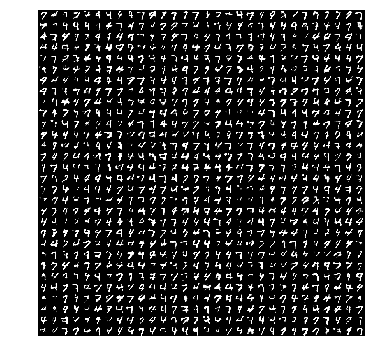

In [52]:
plt.figure(figsize=(20, 20))

n = 30
w, h = 28, 28

generated = np.empty((h * n, w * n))

with torch.no_grad():
    sample = 5 * torch.randn(n**2, 10).to(device)
    sample = model.decode(sample).cpu()

    for i in range(n):
        for j in range(n):
            generated[i * h : (i + 1) * h, j * w : (j + 1) * w] = sample[i * n + j].view(w, h)

plt.figure(figsize=(6, 6))
plt.grid(False)
plt.imshow(generated, cmap='gray')
plt.axis('off')

plt.savefig('generated.png', dpi=400)
plt.show()

In [38]:
five_loader = create_loader_share(train=True, share=[(5, 1.)])

In [45]:
with torch.no_grad():
    for data, _ in five_loader:
        data = data.cuda()
        
        recon_data, mu, logvar = model(data)
        
        print((mu**2).sum(1).mean())

tensor(6.0839, device='cuda:0')
tensor(5.8366, device='cuda:0')
tensor(5.7287, device='cuda:0')
tensor(6.1485, device='cuda:0')
tensor(6.1924, device='cuda:0')
tensor(5.8152, device='cuda:0')
tensor(5.9464, device='cuda:0')
tensor(5.7934, device='cuda:0')
tensor(6.0283, device='cuda:0')
tensor(5.9180, device='cuda:0')
tensor(6.0320, device='cuda:0')
tensor(5.9659, device='cuda:0')
tensor(6.1139, device='cuda:0')
tensor(5.9408, device='cuda:0')
tensor(6.3331, device='cuda:0')
tensor(5.5167, device='cuda:0')
tensor(5.9742, device='cuda:0')
tensor(5.9548, device='cuda:0')
tensor(5.6466, device='cuda:0')
tensor(5.9790, device='cuda:0')
tensor(6.3006, device='cuda:0')
tensor(5.8539, device='cuda:0')
tensor(6.1238, device='cuda:0')
tensor(5.9082, device='cuda:0')
tensor(6.2320, device='cuda:0')
tensor(5.9828, device='cuda:0')
tensor(6.3088, device='cuda:0')
tensor(6.1605, device='cuda:0')
tensor(6.1053, device='cuda:0')
tensor(5.3391, device='cuda:0')
tensor(5.7308, device='cuda:0')
tensor(5

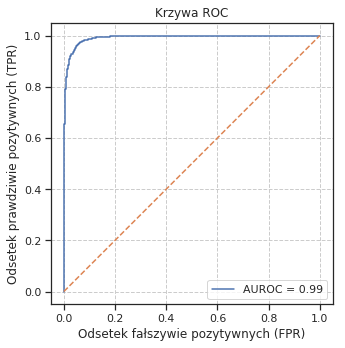

In [23]:
plt.figure(figsize=(5, 5))

cum_loss = X.sum(0)
Ybi = np.in1d(Y, [5]) * 1.0

fpr, tpr, thresholds = roc_curve(Ybi, cum_loss)

area = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUROC = {:.2f}'.format(area))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.gca().set_aspect('equal')
plt.xlabel('Odsetek fałszywie pozytywnych (FPR)')
plt.ylabel('Odsetek prawdziwie pozytywnych (TPR)')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")

# plt.fill(x, y)

plt.grid(True, ls='--')

plt.tight_layout()
plt.show()